In [165]:
import numpy as np
import matplotlib.pyplot as plt # Pylab grafikus megjelenítocsomag importálása
from sklearn import preprocessing

In [166]:
def activation(x):
    return 1 / (1 + np.exp(-x))

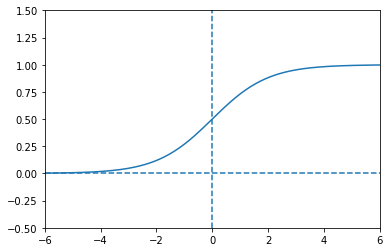

In [167]:
segedX=np.linspace(-6,6,200)

plt.xlim(-6, 6)
plt.ylim(-0.5, 1.5)

plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.plot(segedX,activation(segedX))

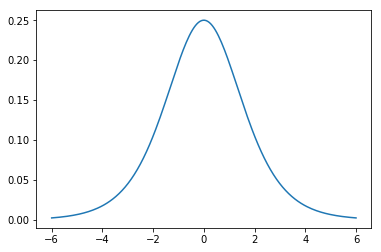

In [168]:
def dactivation(x):
    return np.exp(-x)/((1+np.exp(-x))**2)
plt.plot(segedX,dactivation(segedX))

In [169]:
class MLP:
    
    def __init__(self, *args):
        np.random.seed(123)
        self.shape = args
        n = len(args)
        self.layers = []
        self.layers.append(np.ones(self.shape[0]+1))
        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))
        self.weights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size,
                                         self.layers[i+1].size)))
        self.dw = [0,]*len(self.weights)
        self.reset()
    
    def reset(self):
        for i in range(len(self.weights)):
            Z = np.random.random((self.layers[i].size,self.layers[i+1].size))
            self.weights[i][...] = (2*Z-1)*1

    def propagate_forward(self, data):
        self.layers[0][0:-1] = data
        for i in range(1,len(self.shape)):
            self.layers[i][...] = activation(np.dot(self.layers[i-1],self.weights[i-1]))l
        return self.layers[-1]

    def propagate_backward(self, target, lrate=0.1):
        deltas = []
        error = -(target-self.layers[-1]) 
        delta = np.multiply(error,dactivation(np.dot(self.layers[-2],self.weights[-1])))
        deltas.append(delta)
        for i in range(len(self.shape)-2,0,-1):
            delta=np.dot(deltas[0],self.weights[i].T)*dactivation(np.dot(self.layers[i-1],self.weights[i-1]))
            deltas.insert(0,delta)            
        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i])
            delta = np.atleast_2d(deltas[i])
            dw = -lrate*np.dot(layer.T,delta)
            
            self.weights[i] += dw
                                                                    ##HF2 start Momentum
            alfa = 0.5
            self.weights[i] += alfa*self.dw[i]   #this expression is the difference between normal and Momentum methods
            
                                                                    ##HF2 end Momentum
                
                                                                    ##HF2 start L1
            lambda1 = 0    #lambda1=0 means no regularization
            self.weights[i] += lrate*lambda1*np.sign(self.weights[i])  #this expression is the difference between normal method and L1 regulazitaion
            
                                                                    ##HF2 end L1 
            
                                                                    ##HF2 start L2
            lambda2 = 0    #lambda2=0 means no regularization
            self.weights[i] += lrate*lambda2*self.weights[i]  #this expression is the difference between normal method and L2 regulazitaion
            
                                                                    ##HF2 end L2                 
            self.dw[i] = dw

        return (error**2).sum()

In [170]:
def learn(network, X, Y, valid_split, test_split, epochs=20, lrate=0.1):

        # train-validation-test minták különválasztása
        X_train = X[0:int(nb_samples*(1-valid_split-test_split))]
        Y_train = Y[0:int(nb_samples*(1-valid_split-test_split))]
        X_valid = X[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        Y_valid = Y[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        X_test  = X[int(nb_samples*(1-test_split)):]
        Y_test  = Y[int(nb_samples*(1-test_split)):]
    
        # standardizálás
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test  = scaler.transform(X_test)
    
        # ugyanolyan sorrendben keverjük be a bemeneteket és kimeneteket, a három külön adatbázisra
        randperm = np.random.permutation(len(X_train))
        X_train, Y_train = X_train[randperm], Y_train[randperm]
        randperm = np.random.permutation(len(X_valid))
        X_valid, Y_valid = X_valid[randperm], Y_valid[randperm]
        randperm = np.random.permutation(len(X_test))
        X_test, Y_test = X_test[randperm], Y_test[randperm]
        
        best_valid_err = np.inf
        es_counter = 0 # early stopping counter
        best_model = network
    
        # Tanítási fázis, epoch-szor megyünk át 1-1 véltelenszerűen kiválasztott mintán.
        for i in range(epochs):
            # Jelen megoldás azt a módszert használja, hogy a megadott 
            # tanító adatokon végigmegyünk és minden elemet először végigküldünk
            # a hálózaton, majd terjeszti vissza a kapott eltérést az
            # elvárt eredménytől. Ezt hívjuk SGD-ek (stochastic gradient descent).
            train_err = 0
            for k in range(X_train.shape[0]):
                network.propagate_forward( X_train[k] )
                train_err += network.propagate_backward( Y_train[k], lrate )
            train_err /= X_train.shape[0]

            # validációs fázis
            valid_err = 0
            o_valid = np.zeros(X_valid.shape[0])
            for k in range(X_valid.shape[0]):
                o_valid[k] = network.propagate_forward(X_valid[k])
                valid_err += (o_valid[k]-Y_valid[k])**2
            valid_err /= X_valid.shape[0]

            print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i, train_err, valid_err))

        # Tesztelési fázis
        print("\n--- TESZTELÉS ---\n")
        test_err = 0
        o_test = np.zeros(X_test.shape[0])
        for k in range(X_test.shape[0]):
            o_test[k] = network.propagate_forward(X_test[k])
            test_err += (o_test[k]-Y_test[k])**2
            print(k, X_test[k], '%.2f' % o_test[k], ' (elvart eredmeny: %.2f)' % Y_test[k])
        test_err /= X_test.shape[0]

        fig1=plt.figure()
        plt.scatter(X_test[:,0], X_test[:,1], c=np.round(o_test[:]), cmap=plt.cm.cool)

In [171]:
# Mesterséges neurális hálózat létrehozása, 2 bemenettel, 10 rejtett neuronnal és 1 kimenettel
network = MLP(2,10,1)

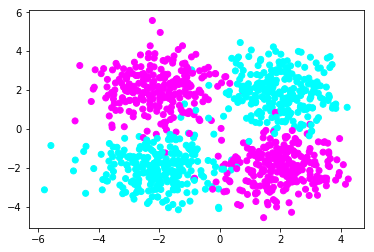

In [172]:
# Tanító, validációs és teszt adatok megadása a rendszernek (zajjal terhelt XOR adatok)
nb_samples=1000
X = np.zeros((nb_samples,2))
Y = np.zeros(nb_samples)
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    X[i], Y[i] = (-2+noise[0],-2+noise[1]), 0
    X[i+1], Y[i+1] = (2+noise[2],-2+noise[3]), 1
    X[i+2], Y[i+2] = (-2+noise[4],2+noise[5]), 1
    X[i+3], Y[i+3] = (2+noise[6],2+noise[7]), 0

# ...és az adatok kirajzolása
fig1=plt.figure()
plt.scatter(X[:,0],X[:,1],c=Y[:], cmap=plt.cm.cool)

0 epoch, train_err: 0.2448, valid_err: 0.2341
1 epoch, train_err: 0.2205, valid_err: 0.2052
2 epoch, train_err: 0.1810, valid_err: 0.1591
3 epoch, train_err: 0.1324, valid_err: 0.1149
4 epoch, train_err: 0.0937, valid_err: 0.0854
5 epoch, train_err: 0.0699, valid_err: 0.0677
6 epoch, train_err: 0.0560, valid_err: 0.0568
7 epoch, train_err: 0.0476, valid_err: 0.0498
8 epoch, train_err: 0.0423, valid_err: 0.0453
9 epoch, train_err: 0.0388, valid_err: 0.0423
10 epoch, train_err: 0.0364, valid_err: 0.0403
11 epoch, train_err: 0.0346, valid_err: 0.0389
12 epoch, train_err: 0.0332, valid_err: 0.0379
13 epoch, train_err: 0.0321, valid_err: 0.0372
14 epoch, train_err: 0.0312, valid_err: 0.0367
15 epoch, train_err: 0.0303, valid_err: 0.0364
16 epoch, train_err: 0.0296, valid_err: 0.0363
17 epoch, train_err: 0.0290, valid_err: 0.0364
18 epoch, train_err: 0.0286, valid_err: 0.0367
19 epoch, train_err: 0.0282, valid_err: 0.0372

--- TESZTELÉS ---

0 [-0.6956089  -1.37664792] 0.00  (elvart eredmeny

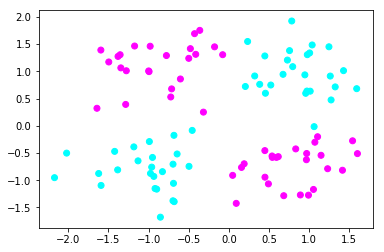

In [173]:
network.reset()
learn(network, X, Y, 0.2, 0.1)